#### Paracode

Laster ned moduler og filer, `module_update`, `nbtext` og `graph_networkx_louvain`

In [1]:
! curl -s "https://raw.githubusercontent.com/Yoonsen/Modules/master/module_update.py" > "module_update.py"

In [2]:
from module_update import update, css, code_toggle, printmd
update('nbtext', overwrite=True)
update('graph_networkx_louvain', overwrite=True)

Updated file `C:\Users\larsj\Documents\GitHub\xmining\nbtext.py`

Updated file `C:\Users\larsj\Documents\GitHub\xmining\graph_networkx_louvain.py`

## Her er noen tilpassede funksjoner

In [3]:
import requests
def normalize_corpus_dataframe(df):
    colsums = df.sum()
    for x in colsums.index:
        #print(x)
        df[x] = df[x].fillna(0)/colsums[x]
    return True

def urn_coll(word, urns=[], after=5, before=5, limit=1000):
    """Find collocations for a word in a set of books represented by URNs.
    Compute a collocation across the books, or pr. book. Both result in a one column dataframe representing
    the collocations.
    """
    
    if isinstance(urns[0], list):  # urns assumed to be list of list with urn-serial as first element
        urns = [u[0] for u in urns]
    
    r = requests.post("https://api.nb.no/ngram/urncoll", json={'word':word, 'urns':urns, 
                                                                   'after':after, 'before':before, 'limit':limit})
    res = pd.DataFrame.from_dict(r.json(), orient='index')
    if not res.empty:
        res = res.sort_values(by=res.columns[0], ascending = False)
    return res

def urn_coll_pr(word, urns=[], after=5, before=5, limit=1000):
        coll = dict()
        for urn in urns:
            cll = urn_coll(word, [urn], after=after, before=before, limit=limit)
            if not cll.empty:
                coll[urn] = cll
        colls = pd.DataFrame.from_dict(coll, orient='index' ).fillna(0)
        normalize_corpus_dataframe(colls)
        scoll = colls.mean(axis=1)
        res = pd.DataFrame(scoll.sort_values(ascending=False))


Aktiver eller fjern `css`

In [4]:
css()

Importer moduler

In [5]:
import nbtext as nb
import graph_networkx_louvain as gnl
import pandas as pd
%matplotlib inline

Slår av advarsler fra IPython

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Notebook for erosmining


Pass på referansene til URN-definisjonene

In [7]:
urns = nb.get_urns_from_docx('../Materiale erotisk litteratur 1945-1970 liste 27.09.18.docx')
print('Antall URNer: ', len(urns), urns[:5])

Antall URNer:  456 ['2015090129001', '2011112308125', '2012021608164', '2016111748512', '2010111706020']


Det kvinnelige materialet

In [8]:
fem_urns = nb.get_urns_from_docx('../Kvinner Materiale erotisk litteratur 1945-1970 liste  08.02.19.docx')
print("Antall: ", len(fem_urns))

Antall:  39


In [9]:
# rekonstruerer metadata for URN-ene
meta = [nb.metadata(u) for u in urns]

In [10]:
# henter 50 000 ord fra totalen
tot = pd.Series(nb.totals(50000))
tot = tot/tot.sum()

# Ekstra kode for kollokasjoner

In [11]:
def collcomp(df_column, comp, exp = 1):
    """df_column is a column in a dataframe - a series, while comp is also a series object"""
    res = (df_column**exp/comp).sort_values(ascending=False)
    return res

In [12]:
import networkx as nx
def make_urn_collocation_graph(target_word, urns, comparo, top = 15, before = 4, after = 4, limit = 1000, exp=1):
        """Make a cascaded network of collocations"""

        firstcoll = urn_coll(target_word, urns, before=before, after=after, limit=limit)
        normalize_corpus_dataframe(firstcoll)
        coll = collcomp(firstcoll[0], comparo, exp = exp)
        target_graf = dict()
        edges = []
        for word in coll[:top].index:
            edges.append((target_word, word))
            if word.isalpha():
                twocoll = urn_coll(word, urns, before=before, after=after,  limit=limit)
                normalize_corpus_dataframe(twocoll)
                coll2 = collcomp(twocoll[0], comparo, exp = exp)
                for w in collcomp(coll2, comparo, exp = exp)[:top].index:
                    if w.isalpha():
                        edges.append((word, w)) 

        target_graph = nx.Graph()
        target_graph.add_edges_from(edges)
        return target_graph

### Kommando for å lage ordsky av en kollokasjon

In [13]:
collcloud = lambda x: nb.cloud(nb.frame(x/x.sum()))

### Kommandoer for ordskyer og grafer

Se eksemplene under.

In [14]:
# noen dictionary-objekter som holder dataene, du slipper å lage nye variable for hver gang
# totalen må være laget, men den er med i initialiseringen av notebooken,sammen med URNene. Se øverst.

Gf = dict()
Colls = dict()

def kollmaker_graph(word, urns, top = 20, before = 5, after = 5, graphdict = Gf, comparo = tot, exp = 1):
    graphdict[word] = make_urn_collocation_graph(word, urns, comparo, top = top, before=before, after=after, exp=1) 
    return True

def kollmaker(word, urns, before = 5, after = 5, colldict = Colls, comparo = tot, exp = 1):
    coll = urn_coll(word, urns, before=before, after=after)
    normalize_corpus_dataframe(coll)
    colldict[word] = collcomp(coll[0], comparo, exp=exp)
    return True

### En hurtigversjon av konkordansekommando

Skriv `konk('bryst')` for å undersøke korpuset. For å se blant URN-er fra kvinner, skriv `konk('bryst', urns=fem_urns)`.

I neste celle defineres kommandoen, med eksempler etter der igjen.

In [36]:
konk = lambda word, urns = urns, before = 8, after = 8, size = 2: nb.get_urnkonk(word, {'urns':nb.refine_urn(urns,{'words':[word]} )[:30], 'before':before, 'after':after, 'size':size})

# Konkordanser


In [39]:
konk('trusen', urns=urns)

"Par, Updike, John, 1969","hennes kom fri fra setet , og trekke",trusen,ned bakfra ; et sekund klamret han seg
"Skjebnens hjul, Robbins, Harold, 1961",så snudde hun seg og tok av seg,trusen,". Hun holdt klesplaggene i hånden , gikk"
"Uten en tråd, Bjørneboe, Jens, 1966","på det , og kjente at inne i",trusen,min begynte min egen glatte saft å renne
"Opera-elskeren, Rifbjerg, Klaus, 1967",munnen for a skjule underansiktet . Stykket mellom,trusen,og strømpene på begge ben hadde hun vist
"Men de må være modne, Vizinczey, Stephen, 1968",med fingrene . Der sto hun i bare,trusen,", men det eneste jeg kunne se ,"
"Men de må være modne, Vizinczey, Stephen, 1968",Fad ikke Bvare . Akkurat da kun BlenFte,trusen,"i anziktet pa Bin venn , kik.ket mannen"
"Høyt spill, Lord, Sheldon, 1960","rive i stykker blusen og skjørtet , og",trusen,var praktisk talt ødelagt . Hun håpet at
"Drømmekvinnen, Lunde, Gunnar, 1970",Det var vakkert da hun strøk av seg,trusen,og den gullyse dotten kom i øynene mine
"Kjærlighet til salgs, Taylor, Robert William, 1960",opp . Camilla hadde lagt igjen den nye,trusen,som hun hadde kjøpt dagen før og som
"Kjærlighet til salgs, Taylor, Robert William, 1960",Han kom plutselig til å tenke på at,trusen,hennes lå under puten hans i køya .
"Kjærlighet til salgs, Taylor, Robert William, 1960",. Se på dette . Han holdt opp,trusen,og viftet med den bort i Eddies ansikt


Lag nye kollokasjoner med `kollmaker('bryst')` for en enkel kollokasjon, eller `kollmaker_graph('bryst', top=20)` for en kompleks graf. Fungerer som før.

Hver gang en av kommandoene kjøres blir de globale variablene `Colls` og `Gf` oppdatert. Det gjør ytterligere variabler overflødig, og en kan finne ut hvor mange ord som er analysert med kommandoene `Colls.keys()` og `Gf.keys()`. Se eksempler nedenfor.

In [17]:
kollmaker('blusen', urns)

True

In [40]:
kollmaker('trusen', urns)

True

In [18]:
kollmaker('lemmet', urns)

True

In [19]:
kollmaker('hoftene', urns)

True

In [46]:
kollmaker('kjærlighet', urns)

True

In [48]:
kollmaker('ømhet', urns)

True

In [49]:
kollmaker('varme', urns)

True

In [55]:
kollmaker('stirret', urns)

True

In [41]:
Colls.keys()

dict_keys(['blusen', 'lemmet', 'hoftene', 'trusen'])

In [21]:
kollmaker_graph('blusen', urns, top=30)

True

In [42]:
kollmaker_graph('trusen', urns, top=30)

True

In [22]:
kollmaker_graph('lemmet', urns, top=30 )

True

In [23]:
kollmaker_graph('hoftene', urns, top=30 )

True

In [51]:
kollmaker_graph('varme', urns, top=30 )

True

In [43]:
Gf.keys()

dict_keys(['blusen', 'lemmet', 'hoftene', 'trusen'])

# Ordskyer for kollokasjonene

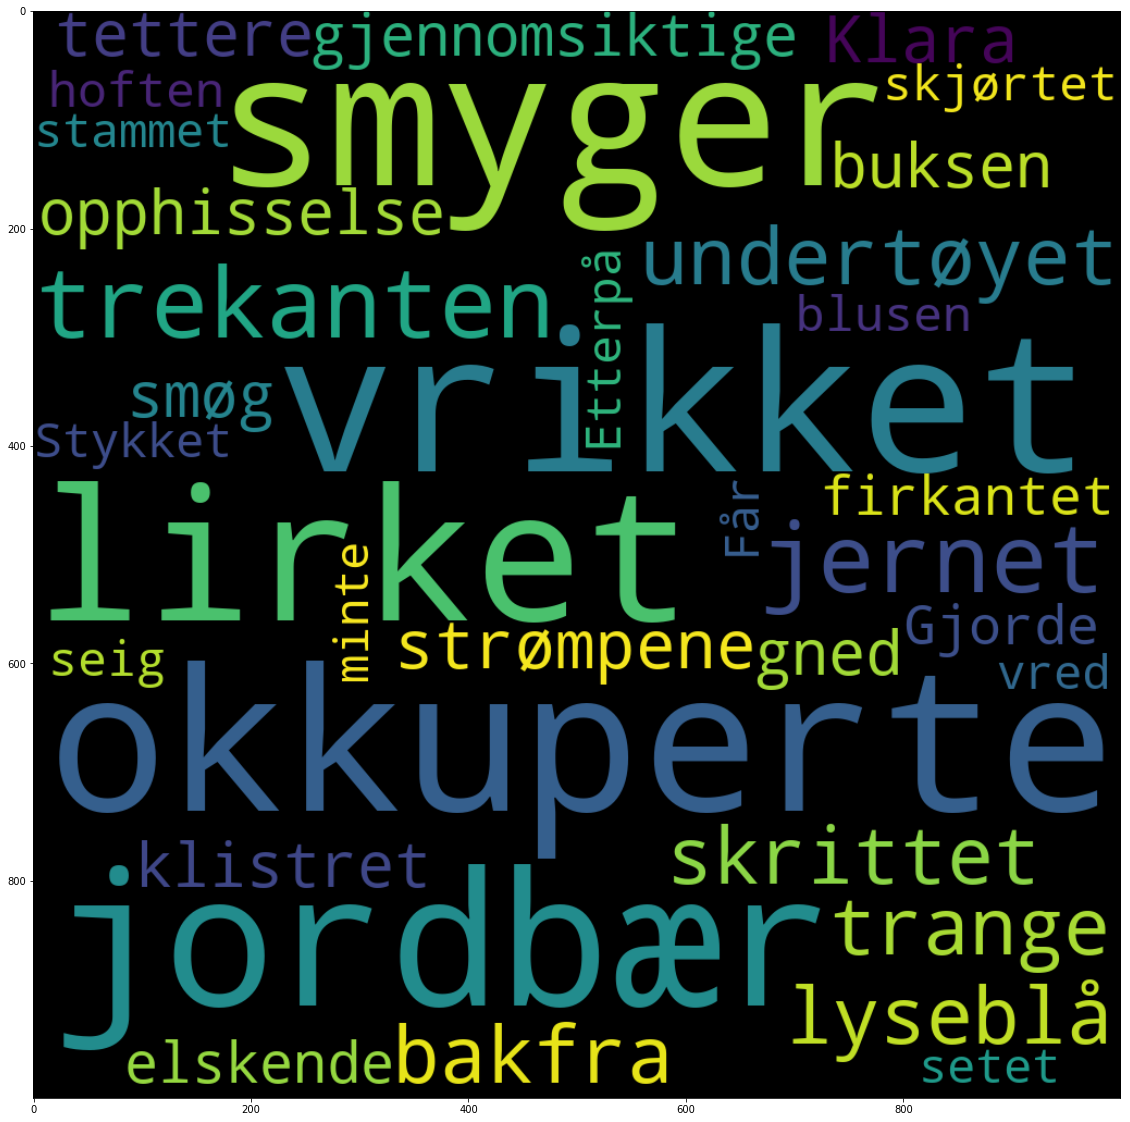

In [44]:
collcloud(Colls['trusen'][:35])

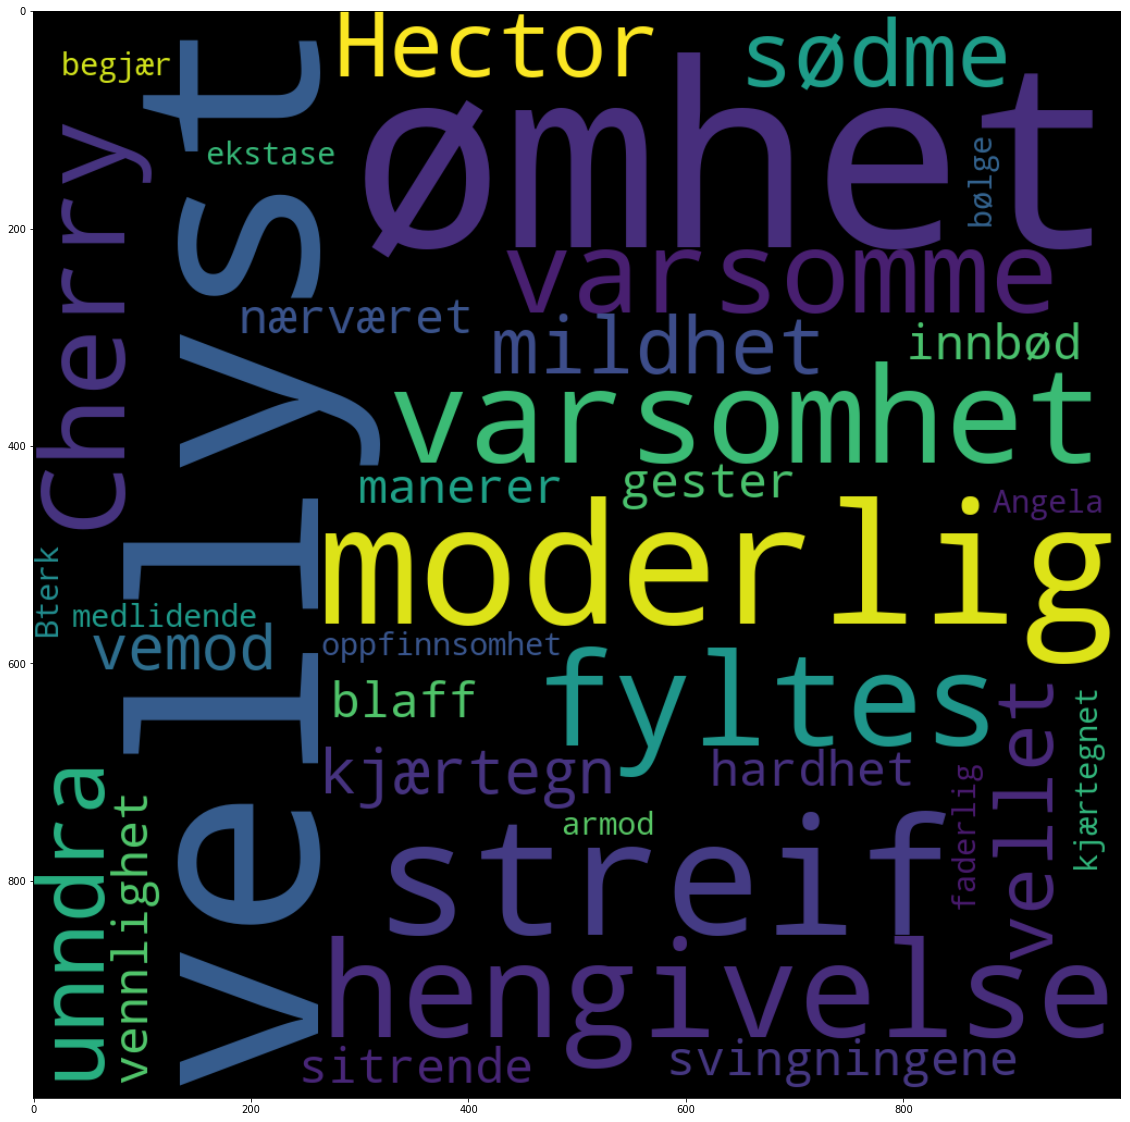

In [57]:
collcloud(Colls['ømhet'][:35])

# Grafer for `Gf`

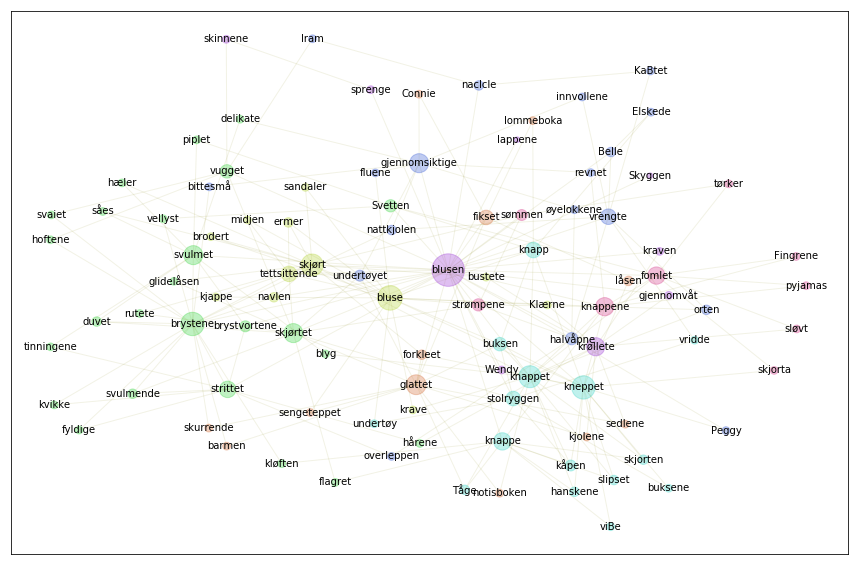

In [26]:
gnl.show_graph(gnl.cutdown(Gf['blusen']))

Klikkstrukturen gir litt informasjon om tette koblinger

In [27]:
gnl.show_cliques(Gf['blusen'])

(3, 1) skjørt, knappene, vugget, kvikke, strømpene, skjørtet, midjen, buksen, fomlet, fyldige, fikset, brystvortene, brodert, undertøyet, navlen, pyjamas, kneppet, strittet, kraven, gjennomvåt, glattet, sandaler, orten, knapp, blusen, knappe, kjappe, sømmen, Wendy, knappet, stolryggen, svulmende, ermer, svulmet, duvet, bluse, krøllete, brystene, Fingrene, tettsittende, Svetten

(3, 2) halvåpne, vrengte, blusen, Belle

(4, 1) knappene, kneppet, bluse, knapp, buksen, blusen

(4, 2) skjørt, bluse, tettsittende, ermer, blusen

(4, 3) knappet, fomlet, blusen, knappene

(4, 4) strittet, brystene, blusen, svulmet, brystvortene



Clustrene kan gi noe også

In [28]:
gnl.show_community(Gf['blusen'])

1 Clyde, elastiske, piplet, underdanig, pungen, tast, sitrende, ribbena, Årene, Wendy, Sina, kjærtegnet, nesebor, brystene, mave, hoven, kvikke, fingertuppene, handflaten, ordens, navlen, opphisselsen, Austria, vellyst, svaiet, tjukke, kjevene, klaser, hemmelighetsfulle, hoftene, innbydende, kjemme, barmen, Sheila, Fullstendig, gnistret, overleppen, selvsikkerhet, overkropp, folde, fyldige, brystvortene, innmat, Brystet, mørkebrune, fyltes, blusen, svamp, hove, børste, stivhet, høydene, blyg, vorten, kjenn, knopper, herligheten, favne, sammen,, Musklene, bøyet, lillefingeren, lommebok, innhegningen, idiotiske, gynget, Minnet, strittet, torner, gjennomvåt, handledd, Bena, ønskene, svulmet, duvet, skurrende, lårene, tinningene, blodårene

2 frakken, bryteren, sikten, mistenksom, slipset, omveier, hissige, lommelykt, krave, seilende, iF, buksene, løselig, Fair, jakker, kneppet, lekre, opptog, teten, dolken, pikken, Peggy, lynsnart, lystret, kløften, olen, skjorta, uopphørlig, tørret, viBe

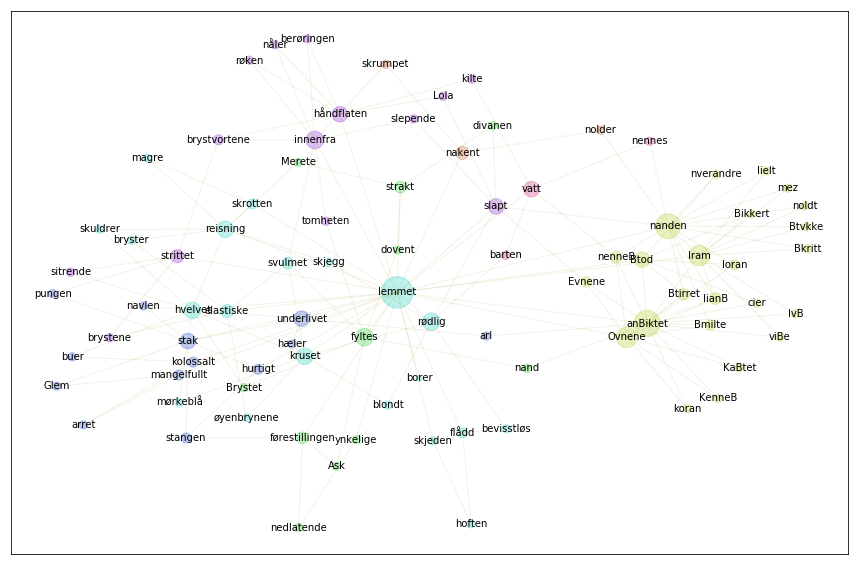

In [29]:
gnl.show_graph(gnl.cutdown(Gf['lemmet']))

In [30]:
gnl.show_cliques(Gf['lemmet'])

(3, 1) blondt, slapt, lram, Bmilte, reisning, noldt, nenneB, mez, skuldrer, lianB, loran, koran, anBiktet, rødlig, KaBtet, Btod, hvelvet, Evnene, cier, KenneB, nanden, kruset, Btvkke, Ovnene, Bkritt, Btirret, magre, IvB, lielt, viBe, lemmet, skrotten, mørkeblå

(3, 2) navlen, stak, hurtigt, underlivet, stangen, lemmet



In [31]:
gnl.show_community(Gf['lemmet'])

1 nan3, lemmet

2 Bmilte, benkene, ganBke, vak, seZ, nder, lutten, Kanß, mana, kraven, Vart, lolk, Btvkke, Btod, noldt, avvergende, ite, Lob, bretter, nolde, Bolen, Btirret, lielt, lram, Majoren, rok, kare, Btund, IvBt, Bkrevet, synene, lekter, vne, omgav, Evnene, degge, denken, Brien, Bnakket, lubben, IVlen, trem, Ze, dsr, iikk, knappet, overvunnet, Btr, vanne, Bkritt, IvB, nverandre, Bikker, Bina, niin, zom, lianB, tangen, fomlet, Bov, FanF, Blett, KenneB, pilte, kvilte, ttun, viBe, BlagB, inen, nenneB, loran, kulle, Ivlen, KaBtet, nolder, bedrevet, Bterk, kjempende, dirrer, nanden, overkor, BZ, elskeren, riggen, mez, errer, clem, ennom, anBiktet, Bikkert, kans, cier, lrem, nennes, raker, Btemme, menß, nvite, ektemenn, Famle, kjetting, koran, Ud, KanB, Kvi, naclcle, utenkor, kottet, sve, nand, berike, Ovnene, dak

3 lillefingeren, Clyde, hoven, overleppen, kvikke, underdanig, fingertuppene, fyldige, handflaten, brystvortene, ordens, strittet, torner, Austria, tast, blusen, tjukke, bø

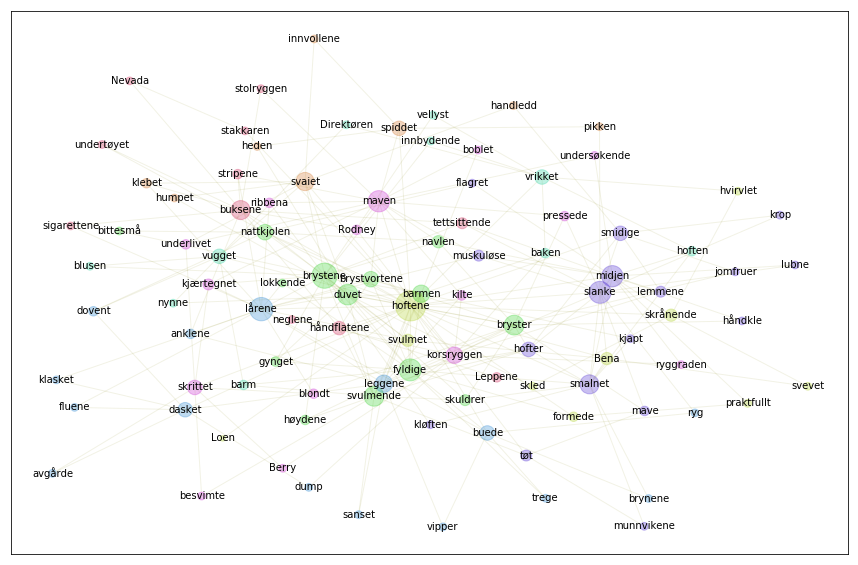

In [32]:
gnl.show_graph(gnl.cutdown(Gf['hoftene']))

In [33]:
gnl.show_cliques(Gf['hoftene'])

(3, 1) bryster, skuldrer, vugget, midjen, fyldige, håndflatene, gynget, brystvortene, formede, navlen, buksene, hofter, tøt, leggene, hoften, krop, muskuløse, svaiet, ribbena, skrånende, nattkjolen, humpet, kjærtegnet, Bena, svulmende, hoftene, buede, høydene, svulmet, barmen, duvet, lemmene, trege, smalnet, lårene, bittesmå, dasket, brystene, slanke, anklene, tettsittende, smidige, lubne

(3, 2) hoftene, spiddet, maven

(4, 1) smalnet, Bena, slanke, hoftene, midjen

(4, 2) lårene, bryster, skuldrer, gynget, svulmende, brystene, hoftene, fyldige, svaiet, brystvortene, svulmet, barmen, duvet



In [34]:
gnl.show_community(Gf['hoftene'])

1 livlig, det, ganske, seg, vannrett, at, hennes, i, ble, Først, hoftene, dager, over, etter, Loen, den, jo

2 båsen, trengselen, bikkja, hvirvlet, nervøsitet, smøg, tilståelse, maktesløs, snodde, flakset, ire, kunstferdig, patroner, ankelen, podiet, Loppa, bykset, beholderen, Edna, vrikket, leven, Pikene, ambassadøren, uttrykksløst, baken, dak

3 Bevegelsen, kvikke, fyldige, hofte, gynget, brystvortene, utstående, innmat, Minnet, søkende, strittet, Matthias, vellyst, leber, elfenben, ribbena, nedbøren, tilbedelse, Sina, klumpete, klaser, kvinnelighet, innbydende, dryppende, underleppen, svulmet, Leppene, skurrende, blyg, trommet, bittesmå, kjenn, datters, favne, brystene, tettsittende

4 Antoinette, flerret, vrengte, majestetisk, strammet, flagret, ryggraden, midjen, tøyet, modenhet, undertøyet, kjærtegn, navlen, slynger, løselig, forvirrede, nennes, røsten, fordreid, Stod, forvillet, uanstendig, hoften, gjennomsiktige, kannen, utslått, glapp, nattkjolen, stønner, Jomfruen, delikate, 

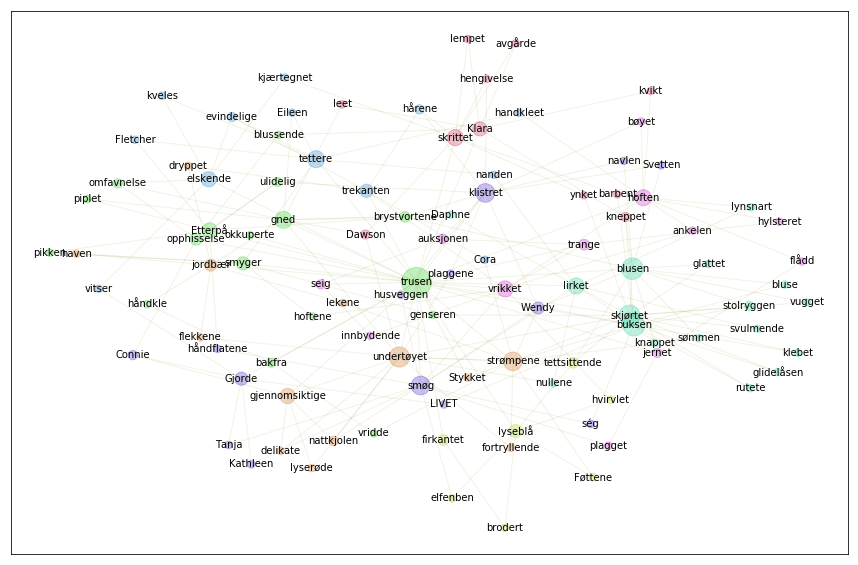

In [45]:
gnl.show_graph(gnl.cutdown(Gf['trusen']))

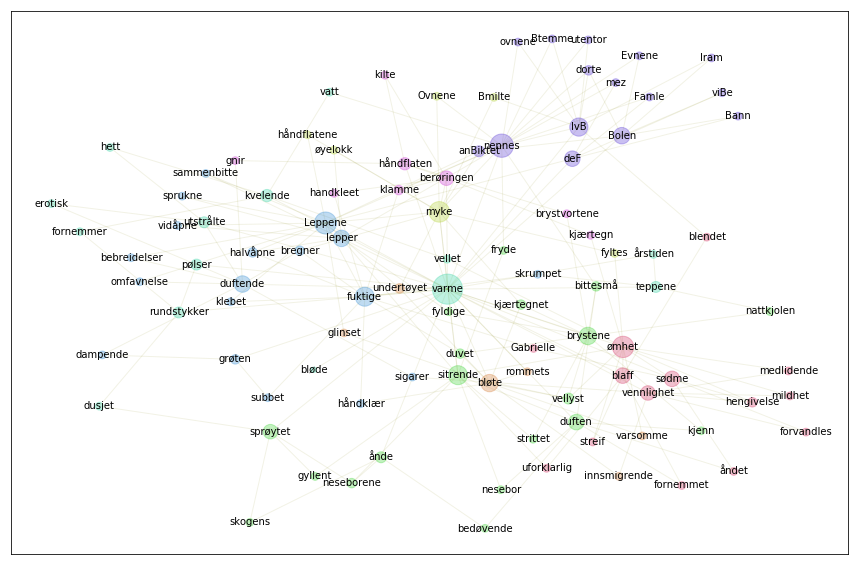

In [52]:
gnl.show_graph(gnl.cutdown(Gf['varme']))

In [54]:
gnl.show_community(Gf['varme'])

1 ømme, Gad, tapetet, kvakk, Smilet, skjerfet, rynkene, kyndige, varme, strømpene, kroppene, sonet, fingertuppene, Gerard, selvsikre, handkleet, tillitsfull, legemlig, brandy, plommer, henrivende, leber, streifer, kjærlige, løsrive, surstoff, underarmen, sleipe, flekkene, grådig, hårene, fuktige, Regnet, lise, metallet, stotte, flammende, tinningene, varsom, frastøtende, formante, hisset, bylten, handleddet, skyggefulle, skled, berøringen, kleber, klamme

2 slimet, legemer, tyggegummi, hugg, ekle, duft, Roberts, gapende, legender, bedøvende, labyrinten, garasjen, bleknet, ujevne, sprut, fremtidens, stinkende, opptar, tellet, Bea, Armene, tilbragt, middagsbordet, partiklene, grådighet, skogens, tømmes, motbydelig, ånde, Salvador

3 stasen, Hvitt, neseborene, rosene, saften, anstrengt, geniale, isnende, skranglet, sprøytet, idiotiske, sæden, maven, tutet, avsluttende, badekaret, doven, styrkende, blodige, fosset, vanvittige, skitt, blomsten, sprøyte, parafin, sæd, fortau

4 pose, kjeks, 